#### Inspired from machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import tensorflow
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [4]:
import keras

In [5]:
def define_discriminator(n_cat, in_shape=(28,28,1)):
    init = keras.initializers.RandomNormal(stddev=0.02)
    in_image = keras.layers.Input(shape=in_shape)
    d = keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = keras.layers.LeakyReLU(alpha=0.1)(d)
    d = keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = keras.layers.LeakyReLU(alpha=0.1)(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.LayerNormalization()(d)
    d = keras.layers.Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
    d = keras.layers.LeakyReLU(alpha=0.1)(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.LayerNormalization()(d)
    d = keras.layers.Flatten()(d)
    out_classifier = keras.layers.Dense(1, activation='sigmoid')(d)
    d_model = keras.models.Model(in_image, out_classifier)
    d_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    q = keras.layers.Dense(128)(d)
    q = keras.layers.BatchNormalization()(q)
    q = keras.layers.LayerNormalization()(q)
    q = keras.layers.LeakyReLU(alpha=0.1)(q)
    out_codes = keras.layers.Dense(n_cat, activation='softmax')(q)
    q_model = keras.models.Model(in_image, out_codes)
    return d_model, q_model

def define_generator(gen_input_size):
    init = keras.initializers.RandomNormal(stddev=0.02)
    in_lat = keras.layers.Input(shape=(gen_input_size,))
    n_nodes = 512 * 7 * 7
    gen = keras.layers.Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = keras.layers.Activation('relu')(gen)
    gen = keras.layers.BatchNormalization()(gen)
    gen = keras.layers.LayerNormalization()(gen)
    gen = keras.layers.Reshape((7, 7, 512))(gen)
    gen = keras.layers.Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
    gen = keras.layers.Activation('relu')(gen)
    gen = keras.layers.BatchNormalization()(gen)
    gen = keras.layers.LayerNormalization()(gen)
    gen = keras.layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = keras.layers.Activation('relu')(gen)
    gen = keras.layers.BatchNormalization()(gen)
    gen = keras.layers.LayerNormalization()(gen)
    gen = keras.layers.Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = keras.layers.Activation('tanh')(gen)
    model = keras.models.Model(in_lat, out_layer)
    return model

def define_gan(g_model, d_model, q_model):
    for layer in d_model.layers:
        if not isinstance(layer, keras.layers.BatchNormalization) and not isinstance(layer, keras.layers.LayerNormalization):
            layer.trainable = False
    d_output = d_model(g_model.output)
    q_output = q_model(g_model.output)
    model = keras.models.Model(g_model.input, [d_output, q_output])
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

def load_real_samples():
    (trainX, _), (_, _) = keras.datasets.mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_cat, n_samples):
    z_latent = np.random.randn(latent_dim * n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)
    cat_codes = np.random.randint(0, n_cat, n_samples)
    cat_codes = keras.utils.to_categorical(cat_codes, num_classes=n_cat)
    z_input = np.hstack((z_latent, cat_codes))
    return [z_input, cat_codes]

def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
    z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
    images = generator.predict(z_input)
    y = np.zeros((n_samples, 1))
    return images, y

def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
            y_gan = np.ones((n_batch, 1))
            _,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
            print('\rEpoch %d/%d: %d/%d, d1: %.3f d2: %.3f, g: %.3f q: %.3f' % (i + 1, n_epochs, j+1, bat_per_epo, d_loss1, d_loss2, g_1, g_2), end='')
        print()

In [6]:
def generate_latent_points_from_cat(latent_dim, n_cat, cat_codes):
    n_samples = len(cat_codes)
    z_latent = np.random.randn(latent_dim * n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)
    cat_codes = keras.utils.to_categorical(cat_codes, num_classes=n_cat)
    z_input = np.hstack((z_latent, cat_codes))
    return z_input

def generate_fake_samples_and_z_from_cat(generator, latent_dim, n_cat, cats):
    n_samples = len(cats)
    z_input = generate_latent_points_from_cat(latent_dim, n_cat, cats)
    images = generator.predict(z_input)
    y = np.zeros((n_samples, 1))
    return images, y, z_input

In [7]:
def plotSome(n):
    codes = [i % n_cat for i in range(n_cat * n)]
    X, y, z = generate_fake_samples_and_z_from_cat(g_model, latent_dim, n_cat, codes)
    plt.subplots(figsize=(n_cat, n))
    for i in range(n_cat * n):
        plt.subplot(n, n_cat, 1 + i)
        plt.axis('off')
        plt.title(codes[i])
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    plt.show()

In [8]:
n_cat = 10
latent_dim = 128
d_model, q_model = define_discriminator(n_cat)
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
gan_model = define_gan(g_model, d_model, q_model)
dataset = load_real_samples()

In [9]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs = 20)

Epoch 1/20: 234/234, d1: 0.213 d2: 0.233, g: 2.966 q: 0.0988
Epoch 2/20: 234/234, d1: 0.168 d2: 0.236, g: 3.679 q: 0.216
Epoch 3/20: 234/234, d1: 0.079 d2: 0.053, g: 4.042 q: 0.238
Epoch 4/20: 234/234, d1: 0.108 d2: 0.159, g: 4.687 q: 0.2221
Epoch 5/20: 234/234, d1: 0.093 d2: 0.069, g: 4.436 q: 0.278
Epoch 6/20: 234/234, d1: 0.046 d2: 0.131, g: 4.853 q: 0.247
Epoch 7/20: 234/234, d1: 0.034 d2: 0.051, g: 5.120 q: 0.2722
Epoch 8/20: 234/234, d1: 1.967 d2: 1.534, g: 6.859 q: 0.503
Epoch 9/20: 234/234, d1: 1.105 d2: 0.790, g: 4.241 q: 0.4030
Epoch 10/20: 234/234, d1: 0.052 d2: 0.215, g: 5.490 q: 0.148
Epoch 11/20: 234/234, d1: 0.120 d2: 0.082, g: 2.928 q: 0.134
Epoch 12/20: 234/234, d1: 0.061 d2: 0.068, g: 3.399 q: 0.054
Epoch 13/20: 234/234, d1: 0.221 d2: 0.245, g: 3.404 q: 0.049
Epoch 14/20: 234/234, d1: 0.081 d2: 0.102, g: 4.261 q: 0.110
Epoch 15/20: 234/234, d1: 0.105 d2: 0.212, g: 3.730 q: 0.069
Epoch 16/20: 234/234, d1: 0.060 d2: 0.056, g: 3.120 q: 0.056
Epoch 17/20: 234/234, d1: 0.0

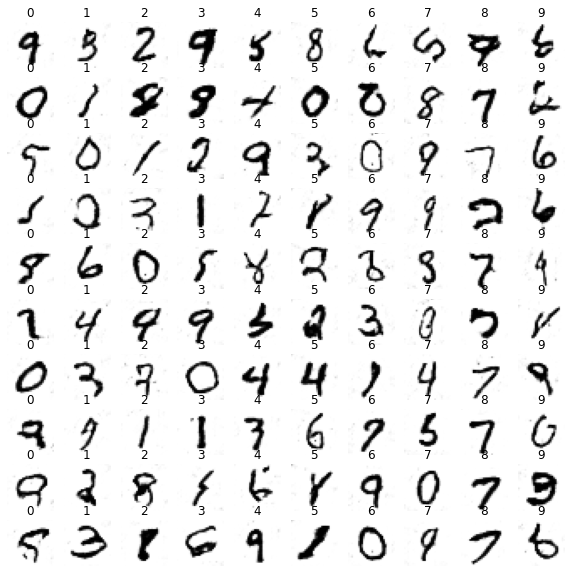

In [10]:
plotSome(10)